In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

In [2]:
df=pd.read_csv('data/crop_production.csv')

In [3]:
df.head(5) 

,index,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,0,AUS,CROPYIELD,RICE,TONNE_HA,A,1990,8.314607,NaN
1,1,AUS,CROPYIELD,RICE,TONNE_HA,A,1991,8.394737,NaN
2,2,AUS,CROPYIELD,RICE,TONNE_HA,A,1992,8.094340,NaN
3,3,AUS,CROPYIELD,RICE,TONNE_HA,A,1993,8.336000,NaN
4,4,AUS,CROPYIELD,RICE,TONNE_HA,A,1994,8.537815,NaN


In [4]:
new_data=df.drop(['index', 'INDICATOR', 'FREQUENCY','Flag Codes'], axis=1)

In [5]:
new_data

,LOCATION,SUBJECT,MEASURE,TIME,Value
0,AUS,RICE,TONNE_HA,1990,8.314607
1,AUS,RICE,TONNE_HA,1991,8.394737
2,AUS,RICE,TONNE_HA,1992,8.094340
3,AUS,RICE,TONNE_HA,1993,8.336000
4,AUS,RICE,TONNE_HA,1994,8.537815
...,...,...,...,...,...
20561,OECD,SOYBEAN,THND_HA,2021,37010.208830
20562,OECD,SOYBEAN,THND_HA,2022,37069.214850
20563,OECD,SOYBEAN,THND_HA,2023,37143.459750
20564,OECD,SOYBEAN,THND_HA,2024,37013.651900


In [6]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20566 entries, 0 to 20565
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LOCATION  20566 non-null  object 
 1   SUBJECT   20566 non-null  object 
 2   MEASURE   20566 non-null  object 
 3   TIME      20566 non-null  int64  
 4   Value     20566 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 803.5+ KB


In [7]:
new_data.isnull().sum()

LOCATION    0
SUBJECT     0
MEASURE     0
TIME        0
Value       0
dtype: int64

<Axes: >

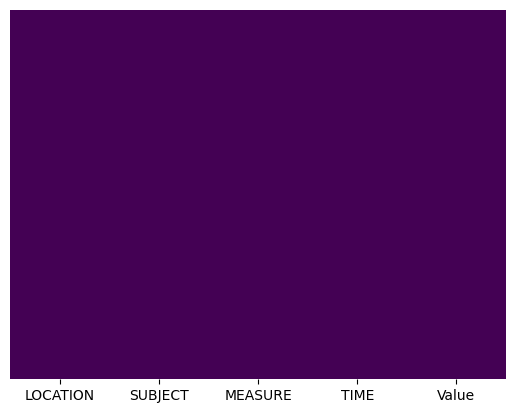

In [8]:
sns.heatmap(data=new_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')

This shows no missing data

### Perparing X and y

In [9]:
X=new_data.drop(columns='Value', axis=1)

In [10]:
X

,LOCATION,SUBJECT,MEASURE,TIME
0,AUS,RICE,TONNE_HA,1990
1,AUS,RICE,TONNE_HA,1991
2,AUS,RICE,TONNE_HA,1992
3,AUS,RICE,TONNE_HA,1993
4,AUS,RICE,TONNE_HA,1994
...,...,...,...,...
20561,OECD,SOYBEAN,THND_HA,2021
20562,OECD,SOYBEAN,THND_HA,2022
20563,OECD,SOYBEAN,THND_HA,2023
20564,OECD,SOYBEAN,THND_HA,2024


In [11]:
y=new_data['Value']

In [12]:
y

0            8.314607
1            8.394737
2            8.094340
3            8.336000
4            8.537815
             ...     
20561    37010.208830
20562    37069.214850
20563    37143.459750
20564    37013.651900
20565    37041.401580
Name: Value, Length: 20566, dtype: float64

In [122]:
# representing y in a dataframe
y=pd.DataFrame(y)

In [123]:
y

,Value
0,8.314607
1,8.394737
2,8.094340
3,8.336000
4,8.537815
...,...
20561,37010.208830
20562,37069.214850
20563,37143.459750
20564,37013.651900


# Identifying categorical and numeric features

In [13]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()  # Adjust as necessary
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Adjust as necessary

In [14]:
categorical_cols

['LOCATION', 'SUBJECT', 'MEASURE']

In [15]:
numerical_cols

['TIME']

# Creating the transformer pipeline

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),  # One-hot encode categorical features
        ('num', MinMaxScaler(), numerical_cols)  # Scale numerical features
    ]
)

# Creating models and parameter tuning

In [17]:
model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {'model__alpha': [0.01, 0.1, 1.0, 10.0]}
    },
    'ElasticNet Regression': {
        'model': ElasticNet(),
        'params': {'model__alpha': [0.1, 1.0, 10.0], 'model__l1_ratio': [0.1, 0.5, 0.9]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'model__max_depth': [3, 5, 10, None], 'model__min_samples_split': [2, 5, 10]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__max_depth': [3, 5, 10, None]}
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.5]}
    },
    'SVR': {
        'model': SVR(),
        'params': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'model__n_neighbors': [3, 5, 7, 9], 'model__weights': ['uniform', 'distance']}
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.5], 'model__max_depth': [3, 5, 10]}
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.5], 'model__max_depth': [3, 5, 10]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0),  # Disable verbose output for CatBoost
        'params': {'model__iterations': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [3, 5, 10]}
    }
}


# Setting up pipe line for hyper parameter tunning using gridsearch cv

In [18]:
# Set up Pipelines and Perform Hyperparameter Tuning using GridSearchCV
best_models = {}
for model_name, mp in model_params.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Apply preprocessing
        ('model', mp['model'])  # Model-specific step
    ])
    
    grid_search = GridSearchCV(pipeline, mp['params'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"{model_name} Best Params: {grid_search.best_params_}")

Linear Regression Best Params: {}
Ridge Regression Best Params: {'model__alpha': 10.0}
Lasso Regression Best Params: {'model__alpha': 10.0}
ElasticNet Regression Best Params: {'model__alpha': 0.1, 'model__l1_ratio': 0.9}
Decision Tree Best Params: {'model__max_depth': None, 'model__min_samples_split': 10}
Random Forest Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
AdaBoost Best Params: {'model__learning_rate': 0.01, 'model__n_estimators': 200}
SVR Best Params: {'model__C': 10, 'model__kernel': 'linear'}
KNN Best Params: {'model__n_neighbors': 5, 'model__weights': 'distance'}
Gradient Boosting Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
XGBoost Best Params: {'model__learning_rate': 0.5, 'model__max_depth': 5, 'model__n_estimators': 100}
CatBoost Best Params: {'model__depth': 3, 'model__iterations': 200, 'model__learning_rate': 0.5}


In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Make Predictions with the Best Tuned Models
predictions = {name: model.predict(X_test) for name, model in best_models.items()}

In [21]:
#Evaluate Accuracy using MAE, MSE, RMSE, R²
results = {}

In [22]:
for name, pred in predictions.items():
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    accuracy_percentage = r2 * 100  # Convert R² to percentage
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2,'Accuracy (%)': accuracy_percentage}

In [23]:
# Display results and select the best model
print("\nModel Performance after Hyperparameter Tuning:")
for model_name, metrics in results.items():
    print(f"{model_name}: MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R²']:.4f}, Accuracy: {metrics['Accuracy (%)']:.2f}%\n")


Model Performance after Hyperparameter Tuning:
Linear Regression: MAE: 18859.1114, MSE: 2067952989.8716, RMSE: 45474.7511, R²: 0.3896, Accuracy: 38.96%

Ridge Regression: MAE: 18723.0167, MSE: 2066125204.2962, RMSE: 45454.6500, R²: 0.3901, Accuracy: 39.01%

Lasso Regression: MAE: 18800.1005, MSE: 2068570162.9068, RMSE: 45481.5365, R²: 0.3894, Accuracy: 38.94%

ElasticNet Regression: MAE: 17507.6508, MSE: 2179778008.0420, RMSE: 46688.0928, R²: 0.3566, Accuracy: 35.66%

Decision Tree: MAE: 370.2604, MSE: 3990724.6579, RMSE: 1997.6798, R²: 0.9988, Accuracy: 99.88%

Random Forest: MAE: 162.6405, MSE: 984527.5446, RMSE: 992.2336, R²: 0.9997, Accuracy: 99.97%

AdaBoost: MAE: 13070.0162, MSE: 1011475681.1946, RMSE: 31803.7055, R²: 0.7014, Accuracy: 70.14%

SVR: MAE: 12289.3711, MSE: 3491862384.4853, RMSE: 59091.9824, R²: -0.0307, Accuracy: -3.07%

KNN: MAE: 0.0000, MSE: 0.0000, RMSE: 0.0000, R²: 1.0000, Accuracy: 100.00%

Gradient Boosting: MAE: 6431.3492, MSE: 277686396.1003, RMSE: 16663.92

#### We will choose XGBoost cause it does not overfit

### Creating a pipeline for xgboost

In [24]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('model', xgb.XGBRegressor(objective='reg:squarederror'))  # XGBoost model
])

In [25]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 10],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

In [26]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['LOCATION',
                                                                          'SUBJECT',
                                                                          'MEASURE']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['TIME'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=Non...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.7, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.5],
                         'model__max_depth': [3, 5, 10],
                         'model__n_estimators': [50, 100, 200],
                         'model__subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [28]:
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best XGBoost Parameters: {best_params}")

Best XGBoost Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__subsample': 0.7}


In [29]:
y_pred = best_xgb_model.predict(X_test)

In [30]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [31]:
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error: 621.8347
Mean Squared Error: 6917015.9369
Root Mean Squared Error: 2630.0220
R² Score: 0.9980


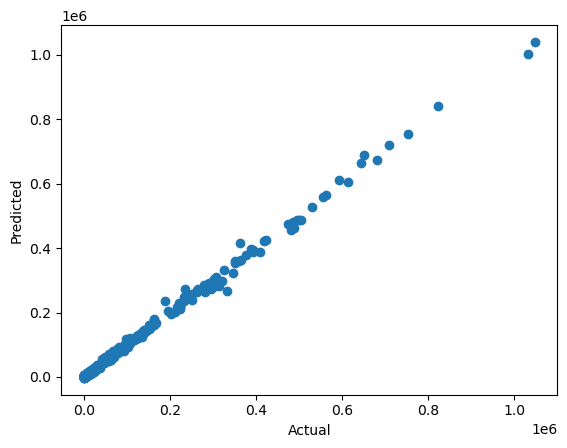

In [32]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');